In [3]:
from genetic_oscillator_benchmarking import *

/home/twright/Documents/PhD/Notebooks/notebooks/Genetic Oscillator/genetic_oscillator_benchmarking.py:102: PyGIWarning: Notify was imported without specifying a version first. Use gi.require_version('Notify', '0.7') before import to ensure that the right version gets loaded.
  from gi.repository import Notify


In [4]:
%display latex

In [5]:
reach = system.reach(
    5, order=4, step=0.003,
    precondition=1,
    estimation=1e-1,
    max_remainder_queue=250,
    integration_method=IntegrationMethod.ONLY_PICARD_SYMB,
    cutoff_threshold=1e-6,
)

In [6]:
reachu = system.reach(
    5, order=4, step=0.003,
    precondition=1,
    estimation=1e-1,
    max_remainder_queue=250,
    integration_method=IntegrationMethod.ONLY_PICARD_SYMB,
    cutoff_threshold=1e-6,
    unprecondition_upfront=True,
)

In [7]:
reach.instrumentor.print()

ran "restoring globals" 1 times in 2.8133392333984375e-05
ran "Running Flow*" 1 times in 74.12620663642883
ran "capturing globals [on exit]" 1 times in 6.031990051269531e-05


In [8]:
reachu.instrumentor.print()

ran "restoring globals" 1 times in 9.059906005859375e-06
ran "Running Flow*" 1 times in 141.26081228256226
ran "prepare" 1 times in 0.08919692039489746
ran "composing flowpipe" 1667 times in 77.37965822219849
ran "unpreconditioning flowpipes" 1 times in 77.42478156089783
ran "capturing globals [on exit]" 1 times in 7.152557373046875e-05


In [10]:
from scipy.integrate import solve_ivp
from lbuc.matricies import vec_to_numpy, mat_to_numpy, convert_vec, sympy_gens

def solution_trajectory(initials):
    RQ, xq = PolynomialRing(RR, 'x1,x2,x3,x4,x5,x6,x7,x8,x9').objgens()
    Qodes = [RQ(yi) for yi in system.y]
    # Make callable function for odes (and jacobian matrix)
    f = vec_to_numpy(RQ, Qodes)
    jac = mat_to_numpy(RQ, jacobian(Qodes, RQ.gens()))
    sln = solve_ivp(f,
                (0, 10),
                initials,
                method='LSODA',
                jac=jac,
                vectorized=True,
                dense_output=True)
    return sln

In [11]:
initials = [x.center() for x in system.y0]
initials

[1.00000000000000,
 1.30000000000000,
 0.100000000000000,
 0.100000000000000,
 0.100000000000000,
 1.30000000000000,
 2.50000000000000,
 0.600000000000000,
 1.30000000000000]

In [12]:
f = solution_trajectory(initials)

In [13]:
f.sol(0)

array([1. , 1.3, 0.1, 0.1, 0.1, 1.3, 2.5, 0.6, 1.3])

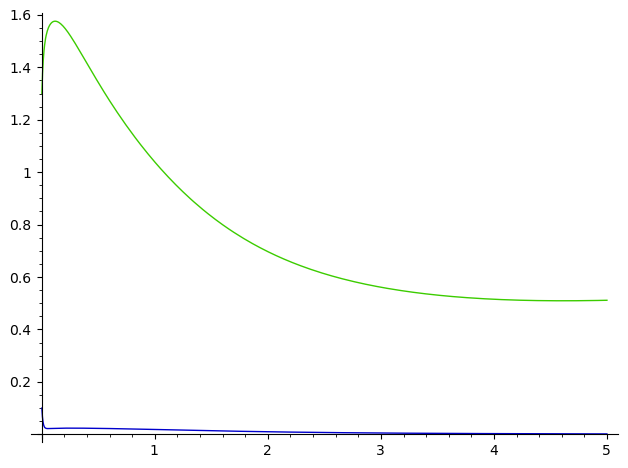

In [14]:
plot((lambda t: f.sol(t)[3], lambda t: f.sol(t)[5]), (0, 5))

In [15]:
def plot_initials(*initials):
    f = solution_trajectory(initials)
    w = parametric_plot(
        (lambda t: f.sol(t)[3], lambda t: f.sol(t)[5]),
        (0, 5),
        color='black',
    )
    w.set_aspect_ratio(1/20)
    return w

In [16]:
def plot_xy(x, y):
    initials = [x.center() for x in system.y0]
    initials[3] = x
    initials[5] = y
    return plot_initials(*initials)

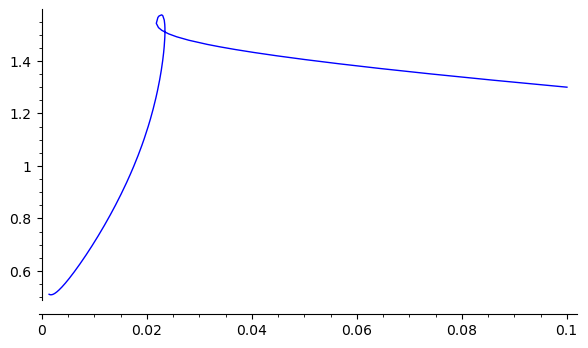

In [17]:
w = parametric_plot((lambda t: f.sol(t)[3], lambda t: f.sol(t)[5]), (0, 5))
w.set_aspect_ratio(1/20)
w

In [18]:
finterval(system.y0[3]), finterval(system.y0[5])

('[0.079999999999999987 .. 0.12000000000000001]',
 '[1.2799999999999998 .. 1.3200000000000001]')

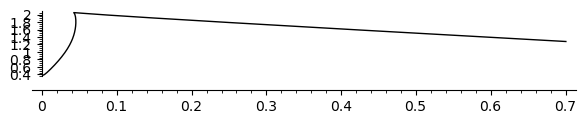

In [19]:
plot_xy(0.7, 1.28)

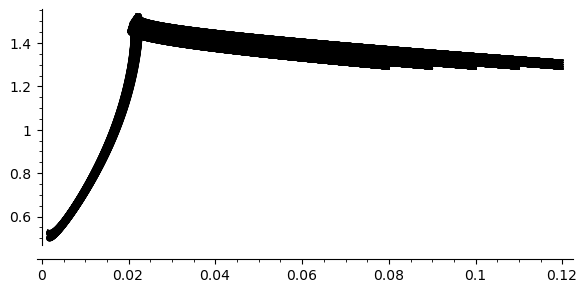

In [20]:
sample=0.04
r = sum(
    (plot_initials(x1,x2,x3,x4,x5,x6,x7,x8,x9)
     for x1 in srange(0.98, 1.02, sample, include_endpoint=True)
     for x2 in srange(1.28, 1.32, sample, include_endpoint=True)
     for x3 in srange(0.08, 0.12, 2*sample, include_endpoint=True)
     for x4 in srange(0.08, 0.12, sample/4, include_endpoint=True)
     for x5 in srange(0.08, 0.12, 2*sample, include_endpoint=True)
     for x6 in srange(1.28, 1.32, sample/4, include_endpoint=True)
     for x7 in srange(2.48, 2.52, sample, include_endpoint=True)
     for x8 in srange(0.58, 0.62, sample, include_endpoint=True)
     for x9 in srange(1.28, 1.32, sample, include_endpoint=True)),
    Graphics(),
)
r

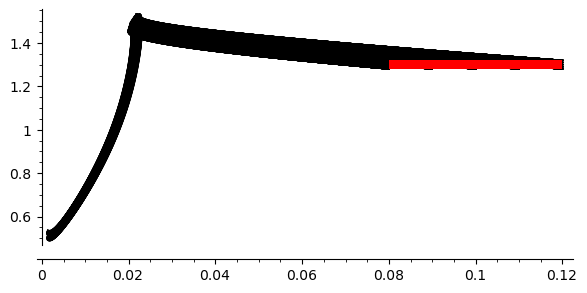

In [21]:
m = r + polygon([(0.08, 1.28), (0.12, 1.28), (0.12, 1.32), (0.08, 1.32)], color='red', zorder=100)
m.set_aspect_ratio(1/20)
m

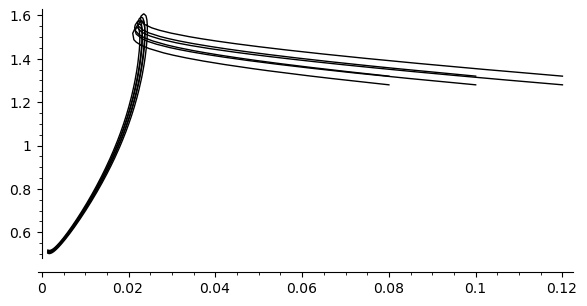

In [22]:
q = sum(
    (plot_xy(x, y)
     for x in srange(0.08, 0.12, 0.02, include_endpoint=True)
     for y in srange(1.28, 1.32, 0.04, include_endpoint=True)),
    Graphics(),
)
q

var_id_x = 3
var_id_y = 5


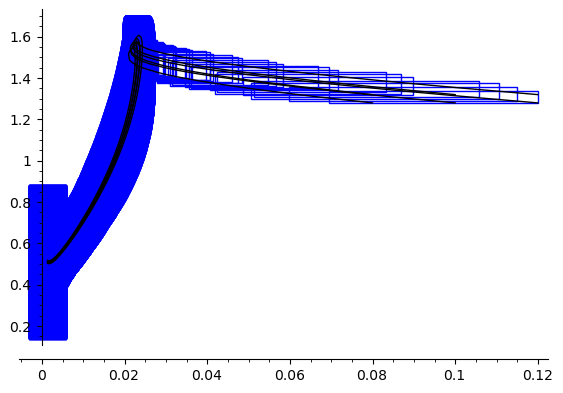

In [23]:
p = reach.sage_interval_plot("x4", "x6", step=1e-3)
p.set_aspect_ratio(1/20)
p + q # m

In [24]:
P = Atomic(var("x6") > 1)
P

Atomic(x6 > 1)

In [25]:
def prop(k):
    return 125**2*(var("x4") - 0.003)**2 + 3*(var("x6") - 0.5)**2 < k

In [26]:
Q = Atomic(prop(0.032)); Q

Atomic(15625*(x4 - 0.00300000000000000)^2 + 3*(x6 - 0.500000000000000)^2 < 0.0320000000000000)

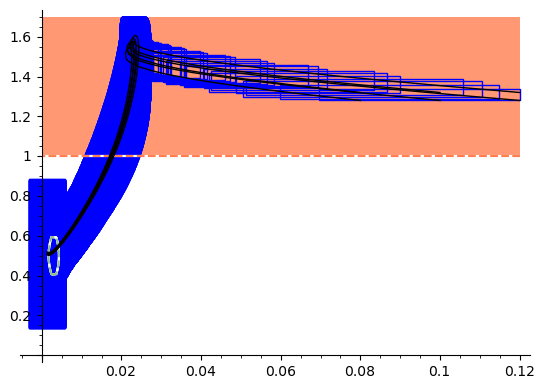

In [27]:
q = p + q
q += region_plot(var("x6") > 1,
                 (x4, 0, 0.12),
                 (x6, 0, 1.7),
                 incol='coral',
                 alpha=0.8,
                 bordercol='coral',
                 borderstyle='--')
q += region_plot(prop(0.032),
                 (x4, 0, 0.12),
                 (x6, 0, 1.7),
                 incol='darkseagreen',
                 alpha=0.8,
                 zorder=10000,
                 bordercol='darkseagreen',
                 borderstyle='--')
q.set_aspect_ratio(1/20)
q

In [28]:
q.save('reach.svg')

PolyObserver(x6 - 1, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 2.96 seconds
roots = [[0.86562109364728989 .. 1.2973760412304721]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
seg_domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
signal given bool roots: 1 items in 0.00 seconds


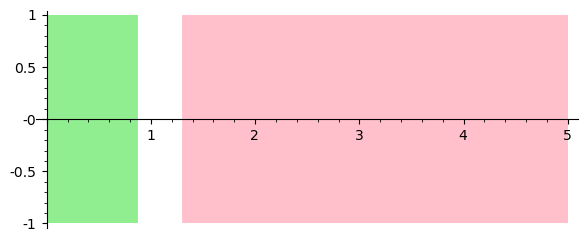

In [29]:
P.signal(reach).plot()

PolyObserver(x6 - 1, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 2.91 seconds
roots = [[0.86562109364728989 .. 1.2973760412304721]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
seg_domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
signal given bool roots: 1 items in 0.00 seconds


/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


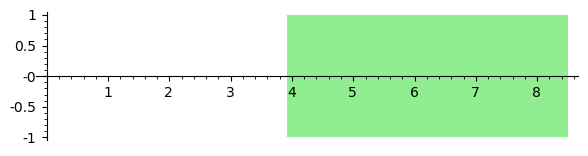

In [30]:
maskP = P.signal(reach).to_mask_or().P(RIF(3, 3.5))
maskP.plot()

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


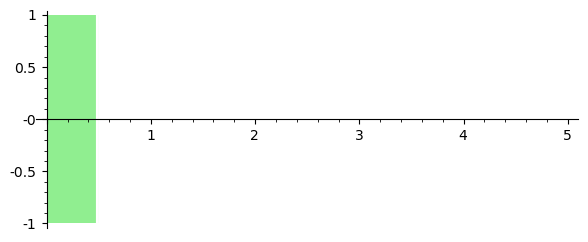

In [31]:
m = Mask(RIF(0, 5), [RIF(0, 0.5)]); m.plot()

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


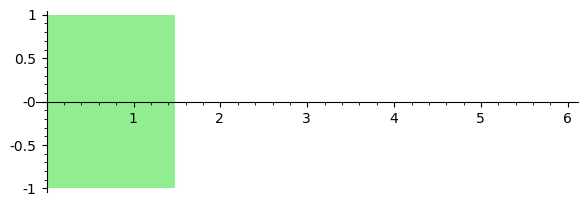

In [32]:
m1 = m.P(RIF(0,1)); m1.plot()

PolyObserver(x6 - 1, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=Mask([0.0000000000000000 .. 6.0000000000000000], [[0.0000000000000000 .. 1.5000000000000000]]))
fprime = -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 1.29 seconds
roots = [[0.86562109364728989 .. 1.2973760412304721]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
seg_domain = [0.0000000000000000 .. 1.5000000000000000]
roots = [[0.86562109364728989 .. 1.2973760412304721]]
signal given bool roots: 1 items in 0.00 seconds


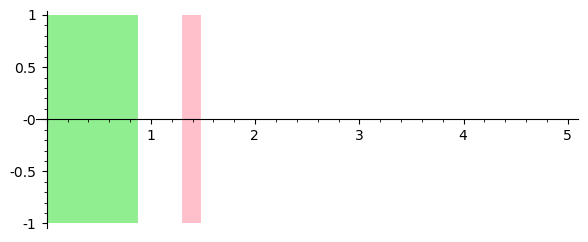

In [33]:
pm1 = P.signal(reach, mask=m1); pm1.plot()

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


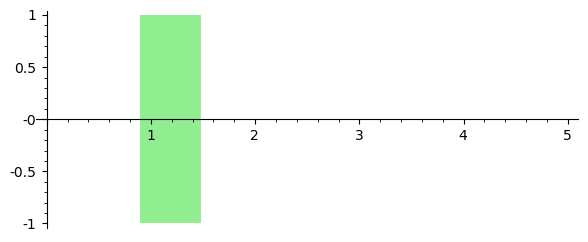

In [34]:
mG = pm1.to_mask_or(); mG.plot()

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


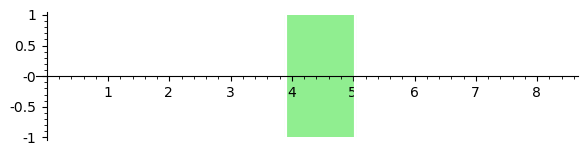

In [35]:
mQ = mG.P(RIF(3,3.5)); mQ.plot()

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 6.31 seconds
roots = [[1.8802545744613263 .. 5.0010000000001532]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[1.8802545744613263 .. 5.0010000000001532]]
seg_domain = [0.00000

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


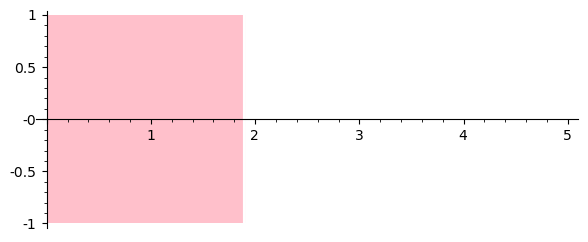

In [36]:
Q.signal(reach).plot()

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=True, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 108.29 seconds
roots = [[2.8917497988991329 .. 2.8920000000000728], [2.8942236766757005 .. 2.8950000000000729], [2.8966944682152040 .. 3.3870000000000915], [4.5237692968526017 .. 4.524000000000

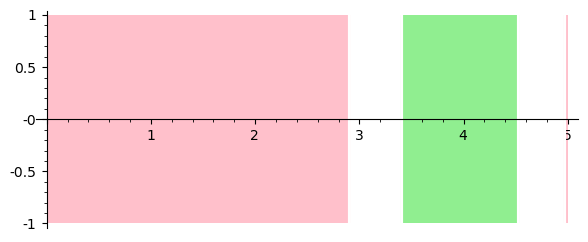

In [37]:
qsigs = Q.signal(reach, symbolic_composition=True)
qsigs.plot()

In [38]:
(P | G(RIF(3, 3.5), Q)).signal(reach, symbolic_composition=True)

PolyObserver(x6 - 1, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6, symbolic_composition=True, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -0.10000000000000000?*x1*x6 - x2*x6 - 2*x6*x8 + 50*x3 + 100*x4 + 50*x5 - x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 2.82 seconds
roots = [[0.89947017268536377 .. 1.2422917684744149]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.89947017268536377 .. 1.2422917684744149]]
seg_domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[0.89947017268536377 .. 1.2422917684744149]]
signal given bool roots: 1 items in 0.00 seconds
In G.signal
PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4

Signal([0.0000000000000000 .. 2.0000000000000000], [([0.0000000000000000 .. 1.0237692968526018], True), ([1.5000000000000000 .. 2.0000000000000000], False)], mask=None)

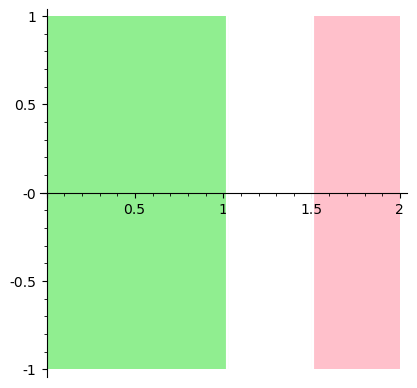

In [39]:
_.plot()

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6


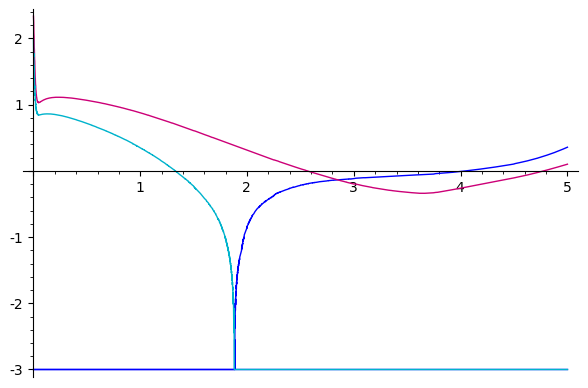

In [40]:
Q.sage_plot(reach,symbolic_composition=False, log=True)

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=True, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6


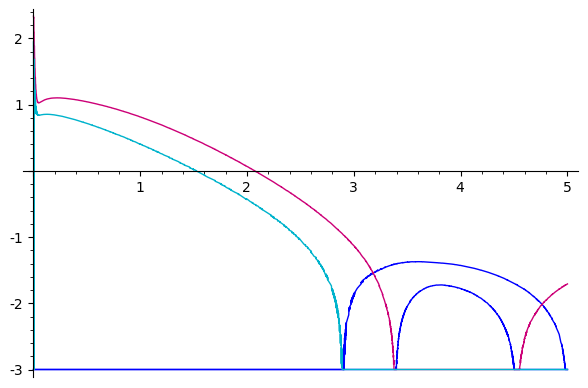

In [41]:
Q.sage_plot(reach,symbolic_composition=True, log=True)

In [62]:
xpltrange = (1.5,5)
ypltrange = (-4.25, 2.25)
ypltrange2 = (-2, 0.1)

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=True, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6


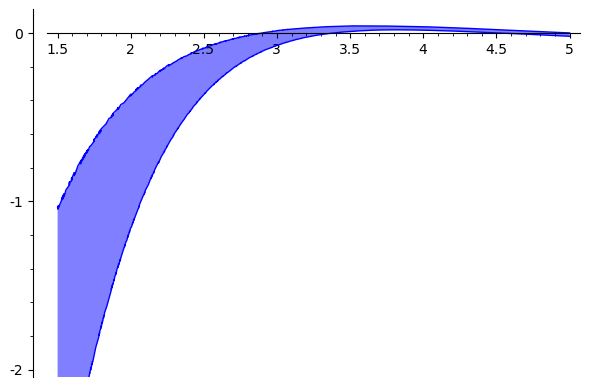

In [43]:
qplt = Q.sage_plot(reach,duration=xpltrange,
                   symbolic_composition=True,
                   ticks=[0.5, 1])
qplt.ymin(ypltrange2[0])
qplt.ymax(ypltrange2[1])
qplt

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6


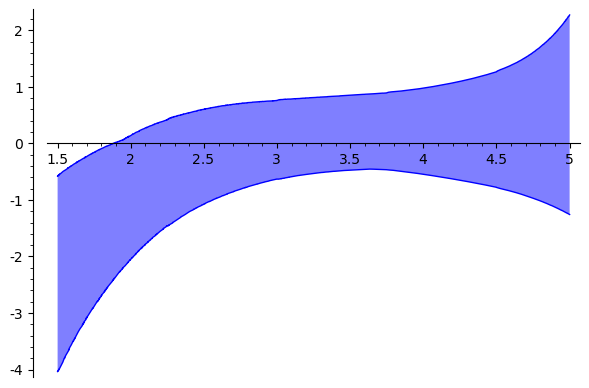

In [44]:
qpltnosym = Q.sage_plot(reach,duration=xpltrange,
                   symbolic_composition=False,
                   ticks=[0.5, 1])
qpltnosym.ymin(ypltrange[0])
qpltnosym.ymax(ypltrange[1])
qpltnosym

In [45]:
sigQnosym = Q.signal(reach, symbolic_composition=False)
sigQnosym

PolyObserver(-15625*x4^2 - 3*x6^2 + 93.75000000000001?*x4 + 3*x6 - 0.858625000000000?, <flowstar.reachability.Reach object at 0x7f0cd65c5ee0>, -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6, symbolic_composition=False, symbolic_composition_order=4, tentative_unpreconditioning=True, mask=None)
fprime = -31250*x2*x4*x6 + 0.600000000000000?*x1*x6^2 + 6*x2*x6^2 + 12*x6^2*x8 + 3125000*x4^2 - 0.3000000000000000?*x1*x6 + 90.750000000000000?*x2*x6 - 300*x3*x6 - 600*x4*x6 - 300*x5*x6 + 6*x6^2 - 6*x6*x8 + 150*x3 - 9075*x4 + 150*x5 - 3*x6
roots(space_domain=None, epsilon=1e-05, verbosity=0)
top-level root detection: 1 items in 6.04 seconds
roots = [[1.8802545744613263 .. 5.0010000000001532]]
domain = [0.0000000000000000 .. 5.0000000000000000]
roots = [[1.8802545744613263 .. 5.0010000000001532]]
seg_domain = [0.00000

Signal([0.0000000000000000 .. 5.0000000000000000], [([0.0000000000000000 .. 1.8802545744613264], False)], mask=None)

In [64]:
ypltrange2=(-4,2)

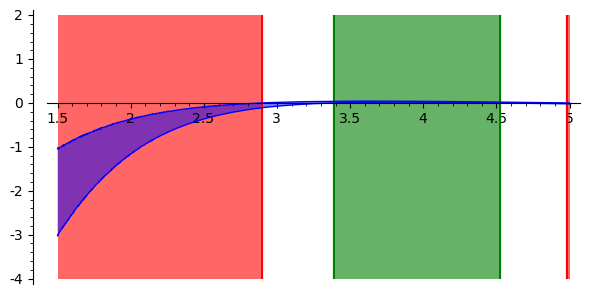

In [72]:
qplt2 = (
    qplt + region_plot(lambda t, _: qsigs(t),
                       xpltrange, ypltrange2, incol='green',
                       bordercol='green',
                       alpha=0.6)
         + region_plot(lambda t, _: qsigs(t) is False,
                       xpltrange, ypltrange2, incol='red',
                       bordercol='red',
                       alpha=0.6)
)
qplt2.ymin(ypltrange2[0])
qplt2.ymax(ypltrange2[1])
#qpltnosym2.ymin(-4)
#qpltnosym2.ymax(2)
# qplt2.set_aspect_ratio(0.76)
qplt2.set_aspect_ratio(0.3)
qplt2

In [73]:
qplt2.save('images/Q-sym-2.pdf', figsize=(4,4))

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


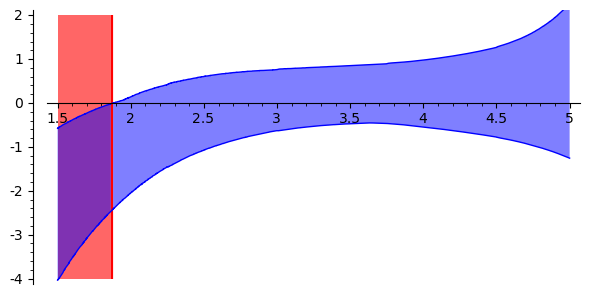

In [71]:
qpltnosym2 = (
    qpltnosym
    + region_plot(lambda t, _: sigQnosym(t),
                  xpltrange, ypltrange2,
                  bordercol='green',
                  incol='green', alpha=0.6)
    + region_plot(lambda t, _: sigQnosym(t) is False,
                  xpltrange, ypltrange2,
                  bordercol='red',
                  incol='red', alpha=0.6)
)
qpltnosym2.ymin(-4)
qpltnosym2.ymax(2)
qpltnosym2.set_aspect_ratio(0.3)
qpltnosym2

In [74]:
qpltnosym2.save('images/Q-no-sym-2.pdf', figsize=(4,4))

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


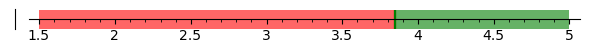

In [50]:
maskplt = (
    region_plot(lambda t, _: maskP(t),
                  xpltrange, (-1, 1),
                  bordercol='green',
                  incol='green', outcol='red', alpha=0.6,
                  ticks=[None,[-2]])
)
maskplt.set_aspect_ratio(1/16)
maskplt

In [51]:
maskplt.save('images/Q-mask.pdf', figsize=(4,4))

/usr/lib64/python3.8/site-packages/sage/plot/contour_plot.py:203: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


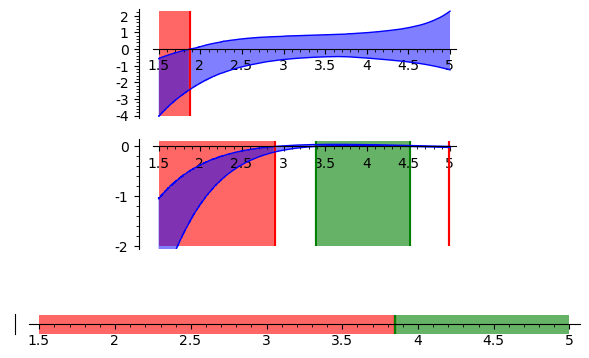

In [52]:
graphics_array([
    qpltnosym2,
    qplt2,
    maskplt,
], ncols=1)